In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import model as md
import time
import pickle

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'SiouxFalls_net.tntp'
trips_name = 'SiouxFalls_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [4]:
graph_data['graph_table']['Init node'].as_matrix()

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,
        7,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11,
       12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22,
       22, 22, 23, 23, 23, 24, 24, 24], dtype=int8)

In [5]:
def costs_func(df, i, j, column):
    rows = df.loc[df['Init node'] == i]
    columns = rows.loc[df['Term node'] == j]
    c = columns[column]
    print(rows)
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return np.nan

def create_T(df):
    T = np.full((n, n), np.nan, dtype=np.double)
    
    i_matrix = df['Init node'].as_matrix()
    j_matrix = df['Term node'].as_matrix()
    
    for i in i_matrix:
        for j in j_matrix:
            data = df.loc[(df['Init node'] == i) & 
                             (df['Term node'] == j)]
            if not data.empty:
                T[i-1][j-1] = data['Free Flow Time'].as_matrix()[0]
    return T

def create_cor_matr(dictnr):
    correspondence_matrix = np.full((n, n), np.nan, dtype=np.double)
    i = 1
    
    for key in dictnr[i].keys():
        for k, v in zip(dictnr[key].keys(),
                    dictnr[key].values()):
            correspondence_matrix[key - 1][k - 1] = v
        i += 1
        
    return correspondence_matrix

In [6]:
correspondence_matrix = create_cor_matr(graph_correspondences)

In [7]:
df = graph_data['graph_table']
df[df['Init node'] == 2].head()

,Init node,Term node,Capacity,Free Flow Time
2,2,1,25900.201172,6.0
3,2,6,4958.181152,5.0


In [8]:
print(df['Init node'].unique())
print(np.sort(df['Term node'].unique()))
print(df['Free Flow Time'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 6.  4.  5.  2.  3. 10.  8.]


In [9]:
df.head()

,Init node,Term node,Capacity,Free Flow Time
0,1,2,25900.201172,6.0
1,1,3,23403.472656,4.0
2,2,1,25900.201172,6.0
3,2,6,4958.181152,5.0
4,3,1,23403.472656,4.0


In [10]:
T = create_T(df)
np.savetxt('T.csv', T, delimiter=',')

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
def distributor_L_W(array):
    max_value = np.max(array)
    max_value_index = np.where(array == np.max(array))
    
    unique, counts = np.unique(array, return_counts=True)
    array_dict = dict(zip(unique, counts))
    print(array_dict)
    zero_num = array_dict[0]
    
    array[max_value_index] = max_value - zero_num
    for index in np.where(array == 0)[0]:
        array[index] = 1.0
    
    return array

In [12]:
L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = L / np.nansum(L)
W = W / np.nansum(W)
print('people_num: ', people_num)

people_num:  360600.0


In [19]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):    
    lambda_L = np.zeros((n, ), dtype=np.double)
    lambda_W = np.zeros((n, ), dtype=np.double)
    
    if k % 2 == 0:
        lambda_W = lambda_W_prev
        lambda_L = np.log(np.nansum(
            (np.exp(-lambda_W_prev - 1 - cost_matrix)).T 
            / L, axis = 0
            ))
    else:
        lambda_L = lambda_L_prev
        lambda_W = np.log(np.nansum(
            (np.exp(-lambda_L - 1 - cost_matrix.T)).T
            / W, axis=0
            ))
        
    return lambda_W, lambda_L

def iterate(cost_matrix, L, W, num_iter, eps):
    
    lambda_L = np.zeros((n, ), dtype=np.double)
    lambda_W = np.zeros((n, ), dtype=np.double)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, 
                                               lambda_Wn - lambda_W)))
        
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
        
        if delta < eps:
            print('ok')
            break
    
    r = error_d_i_j(lambda_Ln, lambda_Wn, cost_matrix)
    return r

def error_d_i_j(lambda_L, lambda_W, cost_matrix):
    er = np.exp( -1 - cost_matrix - (np.reshape(lambda_L, (n, 1)) + lambda_W))
    return er * people_num

In [38]:
num_iter = 2500
alpha, beta = 1.0, 1.0
beta_range = np.arange(0.0, 300, 10)

res_list = []

for beta in beta_range:
    cost_matrix = T * beta * alpha
    rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-2))
    res_list.append(np.linalg.norm(np.nan_to_num(rec, nan = 0.0) 
                                    - np.nan_to_num(correspondence_matrix, nan=0.0)))
    print(beta, np.linalg.norm(np.nan_to_num(rec, nan = 0.0) 
                                    - np.nan_to_num(correspondence_matrix, nan=0.0)))
#     print(np.unique(rec))

0.0 40846.470587537304
10.0 54082.85926667646
20.0 54106.40615848708
30.0 54022.52774858254
40.0 53994.03165962263
50.0 54426.68162179542
60.0 56631.11111207161
70.0 56631.1167483399
80.0 56631.11674523454
90.0 56631.11661972305
100.0 56631.11157963706
110.0 56630.977845687565
120.0 57088.10160557488


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add


130.0 58338.27132803774
140.0 59045.8653661452
150.0 55737.66482265955
160.0 24173.31284550402
170.0 22406.69542792957
180.0 22406.69542792957
190.0 22406.69542792957
200.0 22406.69542792957
210.0 22406.69542792957
220.0 22406.69542792957
230.0 22406.69542792957
240.0 22406.69542792957
250.0 22406.69542792957
260.0 22406.69542792957
270.0 22406.69542792957
280.0 22406.69542792957
290.0 22406.69542792957


In [39]:
np.min(res_list), res_list.index(np.min(res_list)), beta_range[res_list.index(np.min(res_list))]

(22406.69542792957, 17, 170.0)

In [40]:
best_alpha = beta_range[res_list.index(np.min(res_list))]

In [41]:
res_list[0] - res_list[res_list.index(np.min(res_list))]

18439.775159607732

In [42]:
print(np.shape(beta_range), np.shape(res_list))

(30,) (30,)


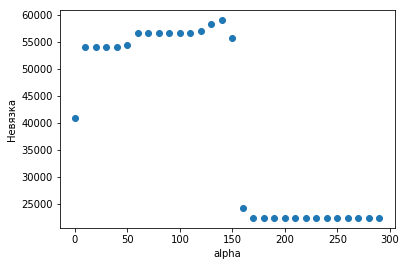

In [43]:
plt.ticklabel_format(useOffset=False)

plt.scatter(beta_range, res_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
# plt.savefig('/Users/kate/Documents/MIPT/ТРАНСПОРТНЫЕ ПОТОКИ/Jupyter:Data/img/1.png')

##### Best recovery corr matrix  

In [ ]:
rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-4))

##### Multi-stage